In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

from vivarium import Artifact

from matplotlib.ticker import ScalarFormatter


!date
!whoami
!pwd

Thu Nov  6 07:00:15 PST 2025
tylerdy
/mnt/share/homes/tylerdy/vivarium_research_alzheimers/plots


In [ ]:
LOCATIONS = [
    "United States of America",
    "Sweden",
    "China",
    "Japan",
    "Brazil",
    "United Kingdom",
    "Germany",
    "Spain",
    "Israel",
    "Taiwan (Province of China)",
]

STAGES = ["Preclinical AD", "MCI due to AD", "AD Dementia"]

YLABEL_MEASURE_LOOKUP = {
    "Incidence": "Incident",
    "Prevalence": "Prevalent",
    "Deaths Associated with AD": "",
}
YLABEL_VALUE_LOOKUP = {
    "Incidence": "Cases",
    "Prevalence": "Population",
    "Deaths Associated with AD": "Deaths",
}

In [4]:
results_dir = "/snfs1/Project/simulation_science/alzheimers/results_10_31_2025"
inc = pd.read_csv(Path(results_dir) / "incidence.csv")
prev = pd.read_csv(Path(results_dir) / "prevalence.csv")
deaths = pd.read_csv(Path(results_dir) / "deaths.csv")
res = pd.concat([prev, inc, deaths])
res

,Year,Location,Age,Sex,Disease Stage,Scenario,Measure,Metric,Mean,95% UI Lower,95% UI Upper
0,2025,Brazil,25_to_29,Female,Preclinical AD,Reference,Prevalence,Number,0.000000,0.000000,0.000000
1,2025,Brazil,25_to_29,Female,MCI due to AD,Reference,Prevalence,Number,0.000000,0.000000,0.000000
2,2025,Brazil,25_to_29,Female,AD Dementia,Reference,Prevalence,Number,0.000000,0.000000,0.000000
3,2025,Brazil,25_to_29,Male,Preclinical AD,Reference,Prevalence,Number,0.000000,0.000000,0.000000
4,2025,Brazil,25_to_29,Male,MCI due to AD,Reference,Prevalence,Number,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
113995,2100,United States of America,95_plus,Male,AD Dementia,BBBM Testing and Treatment,Deaths Associated with AD,Number,7764.612990,5466.617453,10079.971108
113996,2100,United States of America,95_plus,Female,AD Dementia,BBBM Testing Only,Averted Deaths Associated with AD,Number,0.000000,0.000000,0.000000
113997,2100,United States of America,95_plus,Male,AD Dementia,BBBM Testing Only,Averted Deaths Associated with AD,Number,0.000000,0.000000,0.000000
113998,2100,United States of America,95_plus,Female,AD Dementia,BBBM Testing and Treatment,Averted Deaths Associated with AD,Number,-81.315146,-138.475470,-37.700393


In [121]:
def get_loc_ref(df, location, measure):
    df = df.query(
        f"Location == '{location}' & Scenario == 'Reference' & Measure == '{measure}' & Metric == 'Number'"
    )[
        [
            "Year",
            "Location",
            "Age",
            "Sex",
            "Disease Stage",
            "Mean",
            "95% UI Lower",
            "95% UI Upper",
        ]
    ]
    df["Age"] = df["Age"].replace(
        [
            "20_to_24",
            "25_to_29",
            "30_to_34",
            "35_to_39",
            "40_to_44",
            "45_to_49",
            "50_to_54",
            "55_to_59",
        ],
        "20_to_59",
    )
    return df.groupby(list(df.columns)).sum().reset_index()

In [ ]:
def ax_over_time(plot_data, lbl):

    ax = plt.gca()
    ax.plot(plot_data["Year"], plot_data["Mean"], label=lbl)
    ax.fill_between(
        plot_data["Year"],
        plot_data["95% UI Lower"],
        plot_data["95% UI Upper"],
        alpha=0.2,
    )


def plot_over_time(title: str, ylabel: str, scale="linear"):
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2025, 2101, 10))
    plt.yscale(scale)
    if scale == "linear":
        plt.ylim(bottom=0)
    formatter = ScalarFormatter()
    formatter.set_scientific(False)
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.legend(loc=(1.01, 0))
    plt.figure()


def make_forecast_plot(res, location, measure, by_col, scale="linear"):
    scen = "Reference"

    groupby = ["Year"] + ([by_col] if by_col else [])
    by_descr = f" {location} " if location != "All" else " "
    scale_descr = "" if scale == "linear" else " (Log Scale)"

    by_vals = []
    if location == "All":
        by_vals = LOCATIONS
    elif not by_col:
        by_vals = [location]
    else:
        by_vals = sorted(get_loc_ref(res, location, measure)[by_col].unique())

    for val in by_vals:
        loc = val if location == "All" else location
        df = get_loc_ref(res, loc, measure).groupby(groupby).sum().reset_index()
        if by_col:
            df = df[df[by_col] == val]
        ax_over_time(df, val)
        
    plot_over_time(
        f"Forecasted{by_descr}Alzheimer's {measure}, {scen} Scenario (95% UI)",
        f"{YLABEL_MEASURE_LOOKUP[measure]} Alzheimer's {YLABEL_VALUE_LOOKUP[measure]}{scale_descr}",
        scale=scale,
    )

# Baseline (Health and Forecasting) Results

Possible TODOs:
* Rates
* Most plots level out around 2050 - is it ok to show through 2100
* Add age group distribution bar graph for US in 2025, 2037, 2050
* Dashed lines for younger half of age groups in line graphs

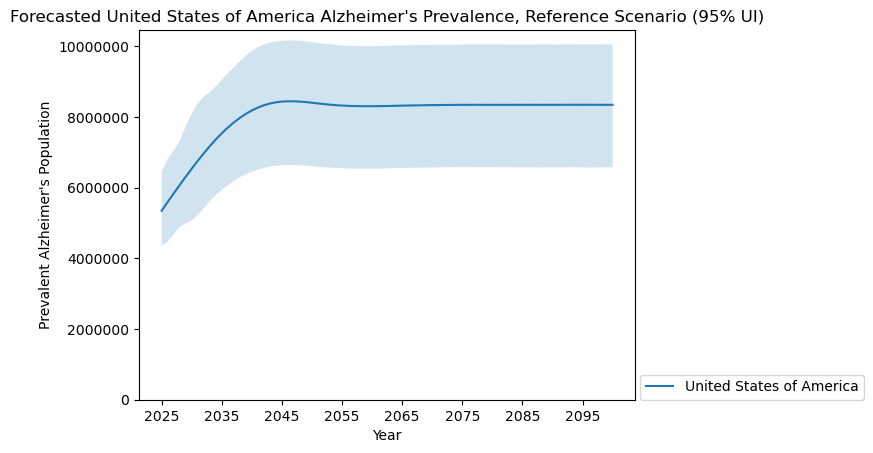

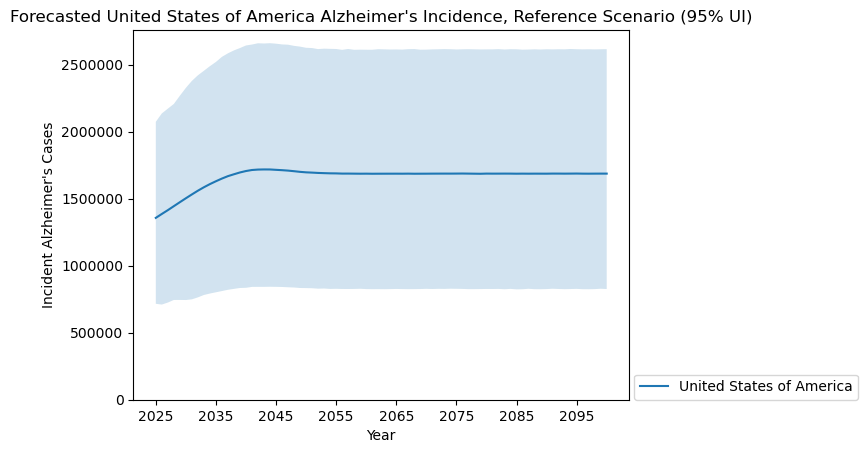

<Figure size 640x480 with 0 Axes>

In [104]:
make_forecast_plot(res, "United States of America", "Prevalence", None)
make_forecast_plot(res, "United States of America", "Incidence", None)

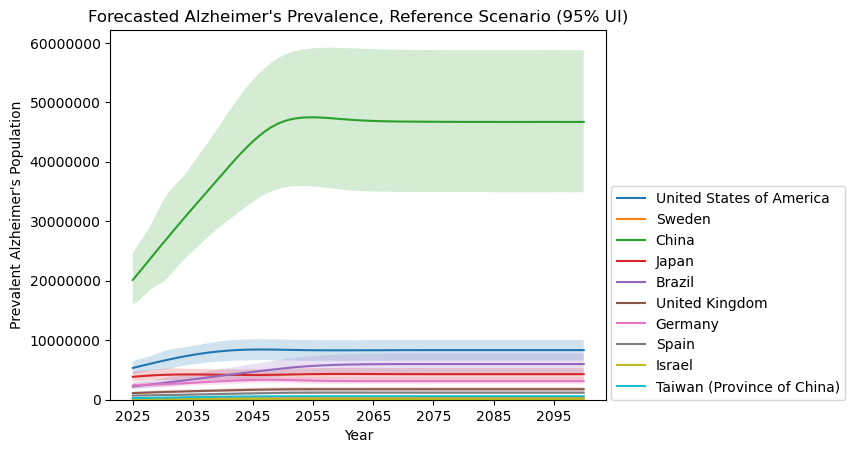

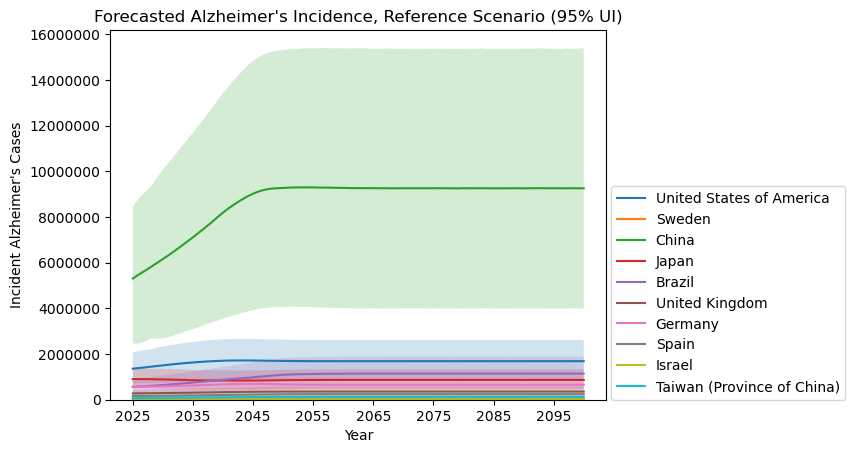

<Figure size 640x480 with 0 Axes>

In [105]:
make_forecast_plot(res, "All", "Prevalence", "Location")
make_forecast_plot(res, "All", "Incidence", "Location")

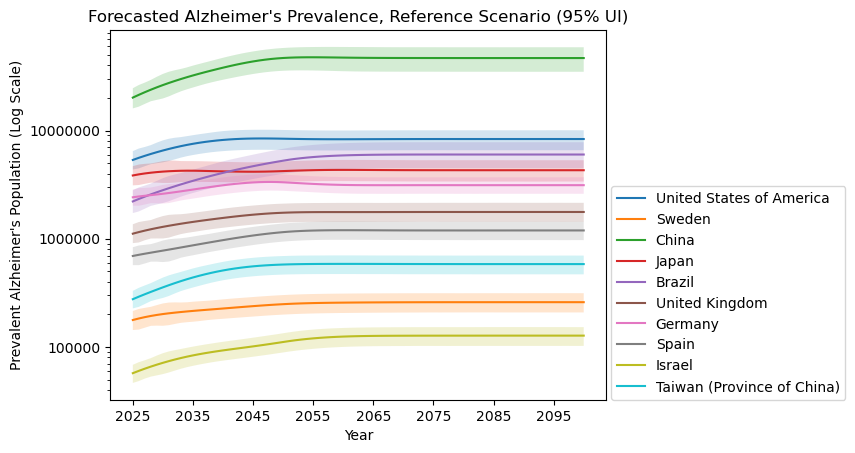

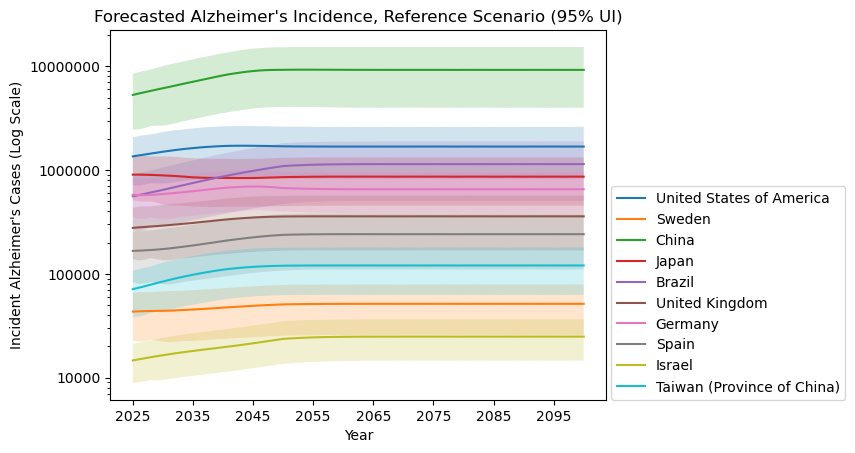

<Figure size 640x480 with 0 Axes>

In [106]:
make_forecast_plot(res, "All", "Prevalence", "Location", scale="log")
make_forecast_plot(res, "All", "Incidence", "Location", scale="log")

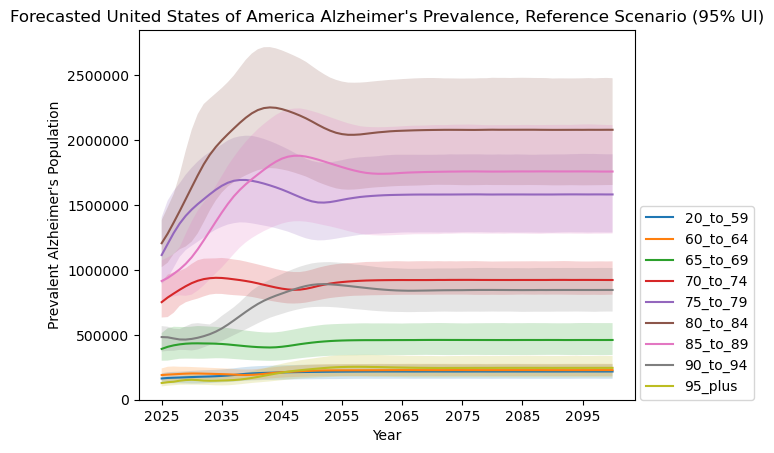

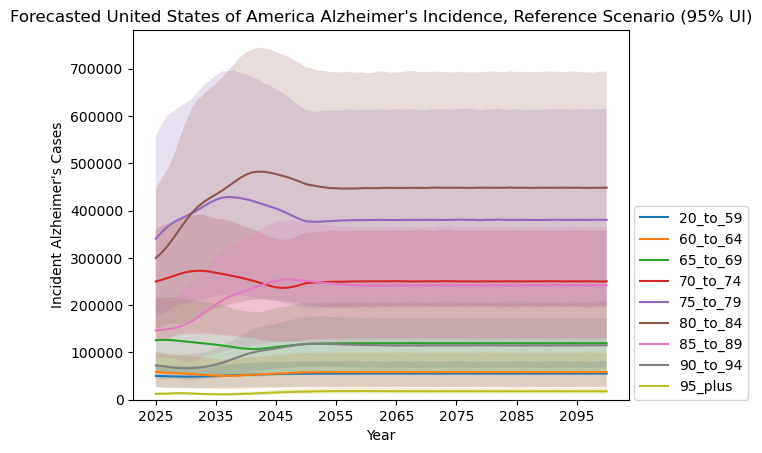

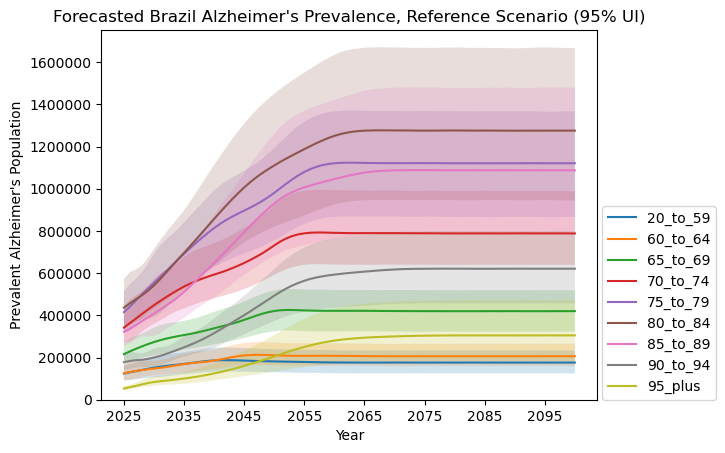

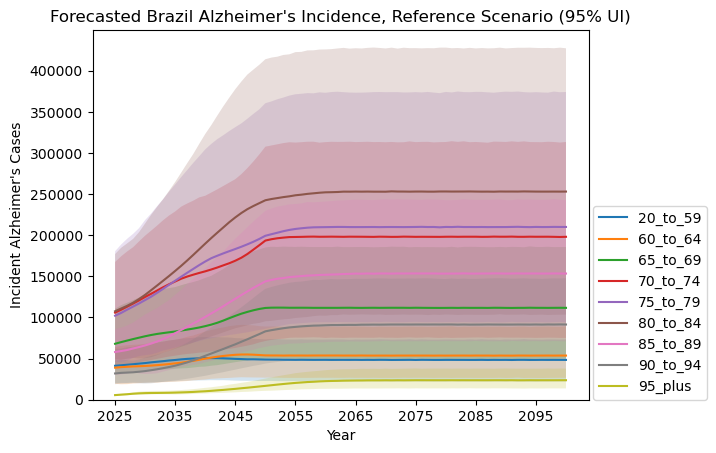

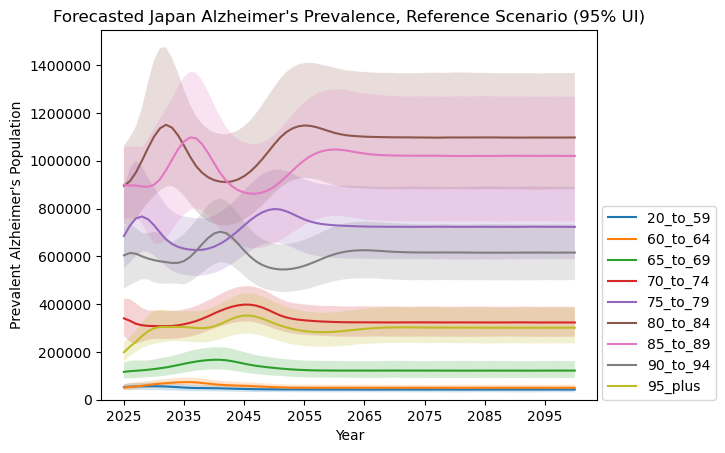

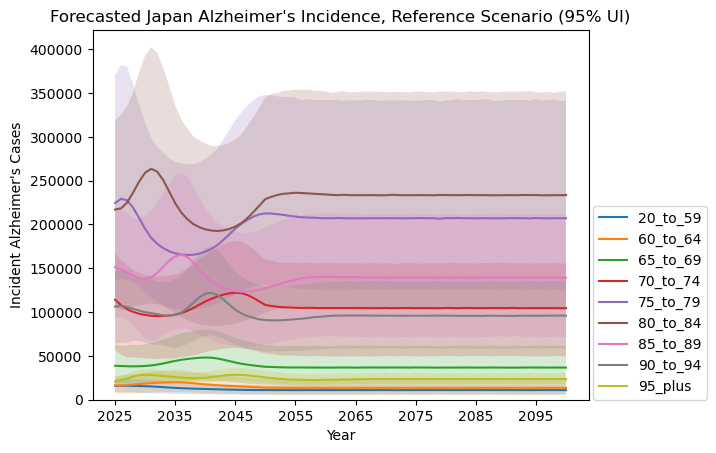

<Figure size 640x480 with 0 Axes>

In [107]:
make_forecast_plot(res, "United States of America", "Prevalence", "Age")
make_forecast_plot(res, "United States of America", "Incidence", "Age")
make_forecast_plot(res, "Brazil", "Prevalence", "Age")
make_forecast_plot(res, "Brazil", "Incidence", "Age")
make_forecast_plot(res, "Japan", "Prevalence", "Age")
make_forecast_plot(res, "Japan", "Incidence", "Age")

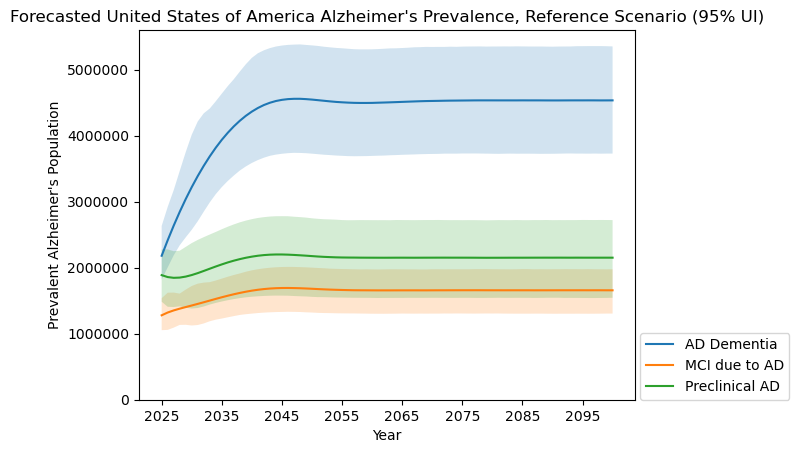

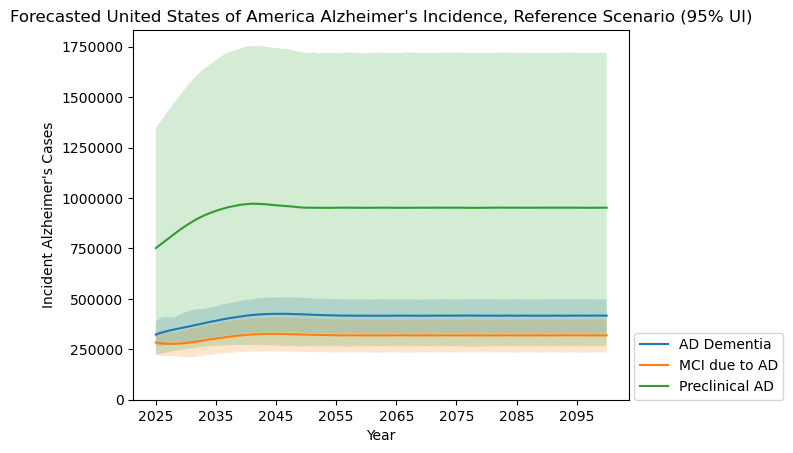

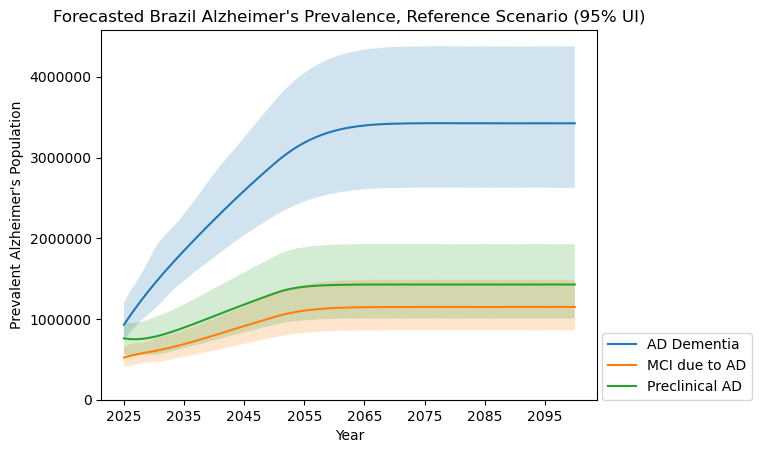

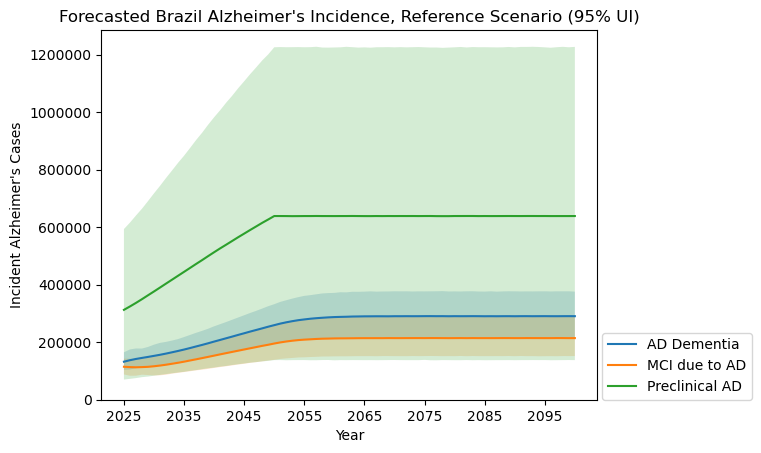

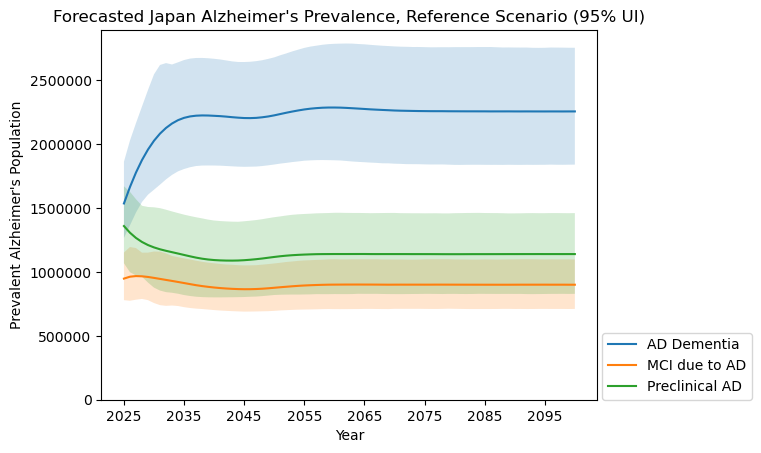

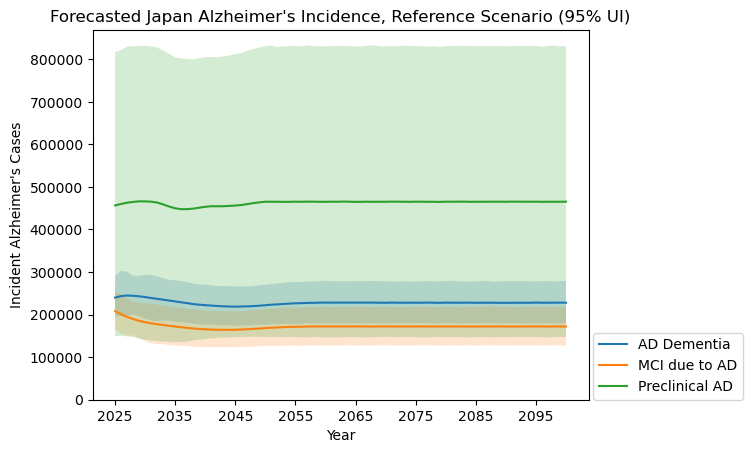

<Figure size 640x480 with 0 Axes>

In [108]:
make_forecast_plot(res, "United States of America", "Prevalence", "Disease Stage")
make_forecast_plot(res, "United States of America", "Incidence", "Disease Stage")
make_forecast_plot(res, "Brazil", "Prevalence", "Disease Stage")
make_forecast_plot(res, "Brazil", "Incidence", "Disease Stage")
make_forecast_plot(res, "Japan", "Prevalence", "Disease Stage")
make_forecast_plot(res, "Japan", "Incidence", "Disease Stage")

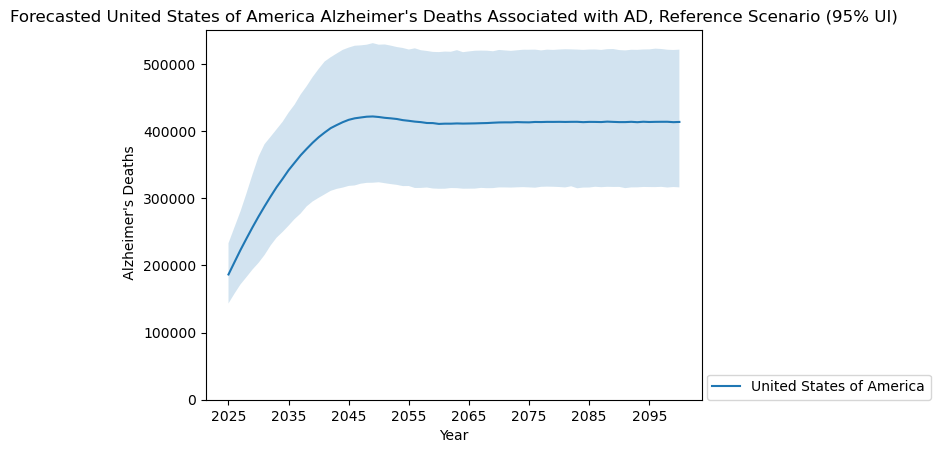

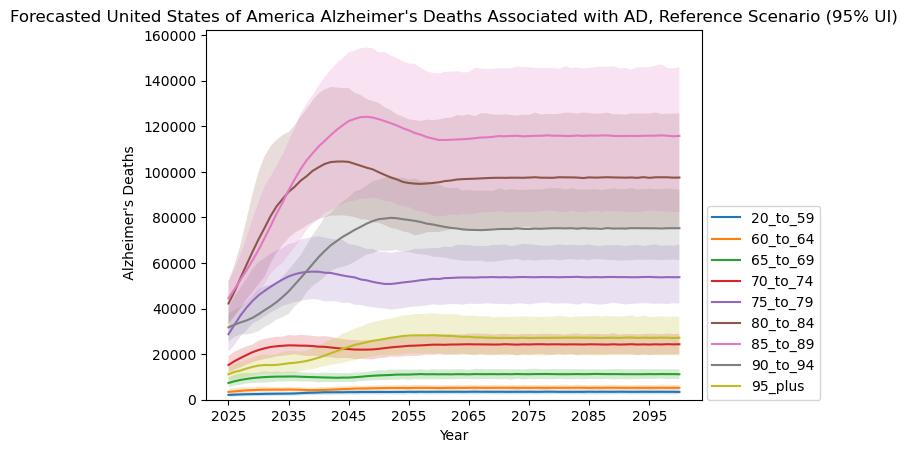

<Figure size 640x480 with 0 Axes>

In [128]:
make_forecast_plot(res, "United States of America", "Deaths Associated with AD", None)
make_forecast_plot(res, "United States of America", "Deaths Associated with AD", "Age")